<h1 style="background-color: #001f3f; color: #ff0; padding: 12px; border: 2px solid #fff; text-align: center;border-radius: 8px;">Human vs AI Text Classifier</h1>

**Due to the very large dataset and the additional data I added myself, processing times became excessively long.**

In [1]:
import pandas as pd
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv("/kaggle/input/ai-vs-human-text/AI_Human.csv")
data.head(7)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
5,The electrol college system is an unfair syste...,0.0
6,"Dear state senator, It is the utmost respect t...",0.0


In [3]:
data['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

In [4]:
data['generated'] = data['generated'].astype(int)

**There is a 40% difference in the distribution of the target value. I'm using an additional dataset to equalize the distribution of the target value.**

In [5]:
extra = pd.read_csv("/kaggle/input/extra/extra.csv")
extra.head(7)

,text,generated
0,Deep neural networks have achieved remarkable ...,1
1,\n\nThe 21st century has seen a rapid evolutio...,1
2,"The chloroplastidan chloroplasts, or green chl...",1
3,In elementary school the officials sold statio...,1
4,"\n\nAs I sat there, pen in hand, gazing out th...",1
5,[title] Take the ferry to isla mujeres. [step]...,1
6,The internet has completely revolutionized the...,1


In [6]:
data = pd.concat([data, extra], axis=0, ignore_index=True)

In [7]:
data.shape

(611235, 2)

In [8]:
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [9]:
data.isnull().sum()

text         0
generated    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611235 entries, 0 to 611234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       611235 non-null  object
 1   generated  611235 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.3+ MB


# Text Preprocessing

In [11]:
data['text'][777]

'Many of us are used to getting somewhere by simply using a car, but should we always use a car. If we limit car usage we can solve most of our problems. We can save comically and collect less polution In source one the German Suburbs are car free, where street parking, driveways, and home garages are forbidden generally. Car ownership is allowed, however where a carowner buys space for their car has to pay near 40,000, along with a home. As a result according to source one 70 percent of vaughn\'s families do not own cars , and 57 percent sold a car to move here. Many citizens complain when the gas prices go up, but if we limit our car usage we wont have to complain anymore. We will save money, because when we decrease the usage of cars we wont use as much gas or diesel. Heidrun Walter told Elisabeth Rosenthal that he now lives happier this way. Not only do we save money but we also relieve tension through out our bodies.\n\nHowever we may not enjoy this new idea of limiting car usage 

**I remove punctuation, numbers and special characters from the text.**

In [12]:
def clean_text(text):
    cleaning_pattern = r'[^a-zA-Z\s]'

    clean_text = re.sub(cleaning_pattern, '', text)

    clean_text = clean_text.replace('\n', ' ')

    clean_text = re.sub(r'\s+', ' ', clean_text)

    return clean_text.strip()

**I will apply the clean_text function I defined above to the text column.**

In [13]:
data['text'] = data['text'].apply(clean_text)

**I'm making all the words lowercase.**

In [14]:
data['text']= data['text'].str.lower()

In [15]:
data['text'][777]

'many of us are used to getting somewhere by simply using a car but should we always use a car if we limit car usage we can solve most of our problems we can save comically and collect less polution in source one the german suburbs are car free where street parking driveways and home garages are forbidden generally car ownership is allowed however where a carowner buys space for their car has to pay near along with a home as a result according to source one percent of vaughns families do not own cars and percent sold a car to move here many citizens complain when the gas prices go up but if we limit our car usage we wont have to complain anymore we will save money because when we decrease the usage of cars we wont use as much gas or diesel heidrun walter told elisabeth rosenthal that he now lives happier this way not only do we save money but we also relieve tension through out our bodies however we may not enjoy this new idea of limiting car usage some of us actually enjoy driving but

# Tokenization

In [16]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

data['tokenized_text'] = data['text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
data.head()

,text,generated,tokenized_text
0,cars cars have been around since they became f...,0,"[cars, cars, have, been, around, since, they, ..."
1,transportation is a large necessity in most co...,0,"[transportation, is, a, large, necessity, in, ..."
2,americas love affair with its vehicles seems t...,0,"[americas, love, affair, with, its, vehicles, ..."
3,how often do you ride in a car do you drive a ...,0,"[how, often, do, you, ride, in, a, car, do, yo..."
4,cars are a wonderful thing they are perhaps on...,0,"[cars, are, a, wonderful, thing, they, are, pe..."


# StopWords

In [18]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

In [20]:
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: remove_stopwords(x))

In [21]:
data['tokenized_text'][777]

['many',
 'us',
 'used',
 'getting',
 'somewhere',
 'simply',
 'using',
 'car',
 'always',
 'use',
 'car',
 'limit',
 'car',
 'usage',
 'solve',
 'problems',
 'save',
 'comically',
 'collect',
 'less',
 'polution',
 'source',
 'one',
 'german',
 'suburbs',
 'car',
 'free',
 'street',
 'parking',
 'driveways',
 'home',
 'garages',
 'forbidden',
 'generally',
 'car',
 'ownership',
 'allowed',
 'however',
 'carowner',
 'buys',
 'space',
 'car',
 'pay',
 'near',
 'along',
 'home',
 'result',
 'according',
 'source',
 'one',
 'percent',
 'vaughns',
 'families',
 'cars',
 'percent',
 'sold',
 'car',
 'move',
 'many',
 'citizens',
 'complain',
 'gas',
 'prices',
 'go',
 'limit',
 'car',
 'usage',
 'wont',
 'complain',
 'anymore',
 'save',
 'money',
 'decrease',
 'usage',
 'cars',
 'wont',
 'use',
 'much',
 'gas',
 'diesel',
 'heidrun',
 'walter',
 'told',
 'elisabeth',
 'rosenthal',
 'lives',
 'happier',
 'way',
 'save',
 'money',
 'also',
 'relieve',
 'tension',
 'bodies',
 'however',
 'may'

# Lemmatization

**Unfortunately, I can't run the lemmatization code in Kaggle because the data set is too large and it terminates the session. Remove the comment lines when using it locally.**

In [22]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

data['lemmatized_text'] = data['tokenized_text'].apply(lemmatize_text)

# Model

In [23]:
X = data['lemmatized_text']
y = data['generated']

In [24]:
data['generated'].value_counts()

generated
0    305797
1    305438
Name: count, dtype: int64

In [25]:
X = [' '.join(doc) for doc in X]

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline

1. Naive Bayes

2. Logistic Regression

3. XGBoost


## Naive Bayes

In [27]:
pipeline_bayes = Pipeline([
    ('count_vectorizer', CountVectorizer()), # Creates vectors using only word frequencies.
    ('tfidf_transformer', TfidfTransformer()), # Determines uniqueness between documents and highlights important words.
    ('naive_bayes', MultinomialNB())]) # Model

In [28]:
pipeline_bayes.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('naive_bayes', MultinomialNB())])

In [29]:
y_pred_naive_bayes = pipeline_bayes.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(y_test, y_pred_naive_bayes)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_naive_bayes, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9478351206982585
Precision: 0.9497142383396154
Recall: 0.9478351206982585
F1 Score: 0.947779535725434


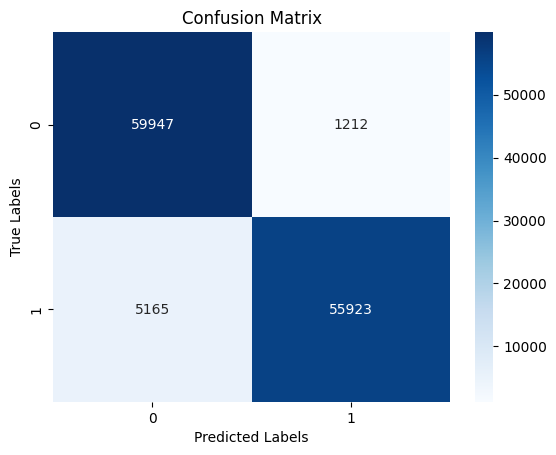

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_naive_bayes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

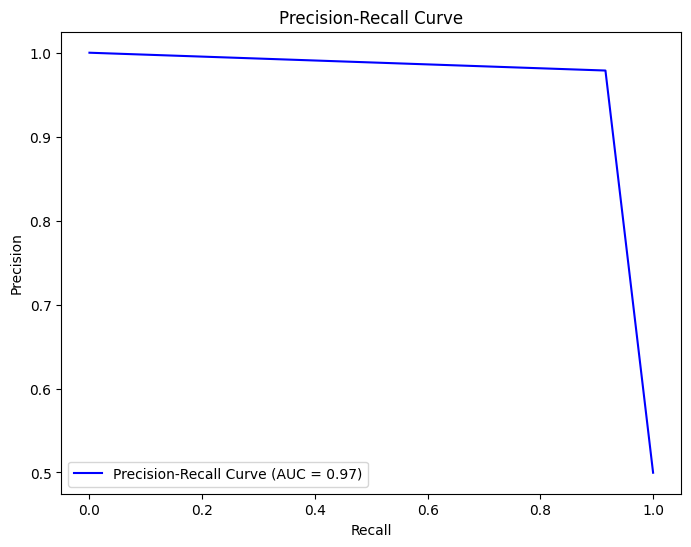

In [32]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_pred_naive_bayes)
auc_score = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

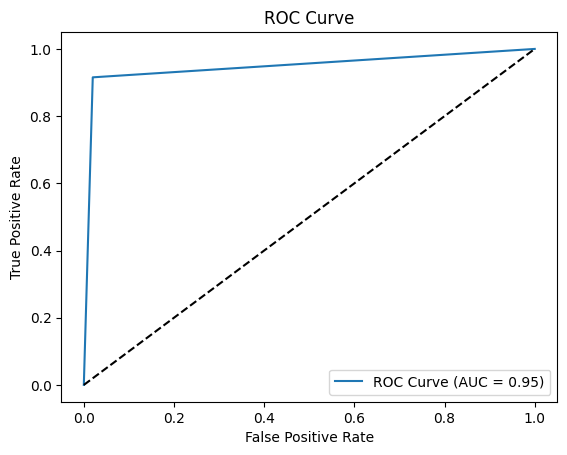

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_naive_bayes)
auc = roc_auc_score(y_test, y_pred_naive_bayes)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Logistic Regression

In [34]:
pipeline_logistic = Pipeline([
    ('count_vectorizer', CountVectorizer()), # Creates vectors using only word frequencies.
    ('tfidf_transformer', TfidfTransformer()), # Determines uniqueness between documents and highlights important words.
    ('logistic_regression', LogisticRegression()) # Model
])

In [35]:
pipeline_logistic.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('logistic_regression', LogisticRegression())])

In [36]:
y_pred_logistic = pipeline_logistic.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(y_test, y_pred_logistic)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_logistic, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9924251719878606
Precision: 0.992429524771137
Recall: 0.9924251719878606
F1 Score: 0.9924251486484371


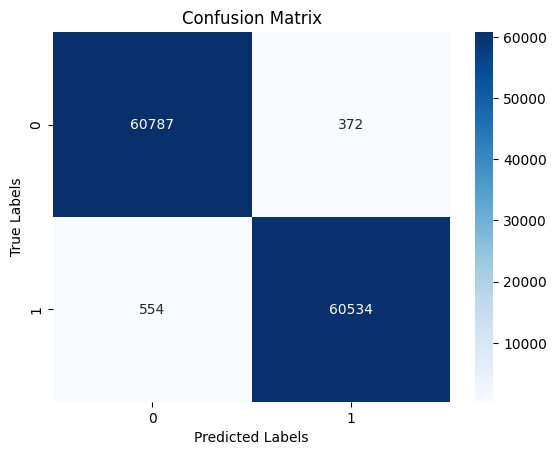

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_logistic)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

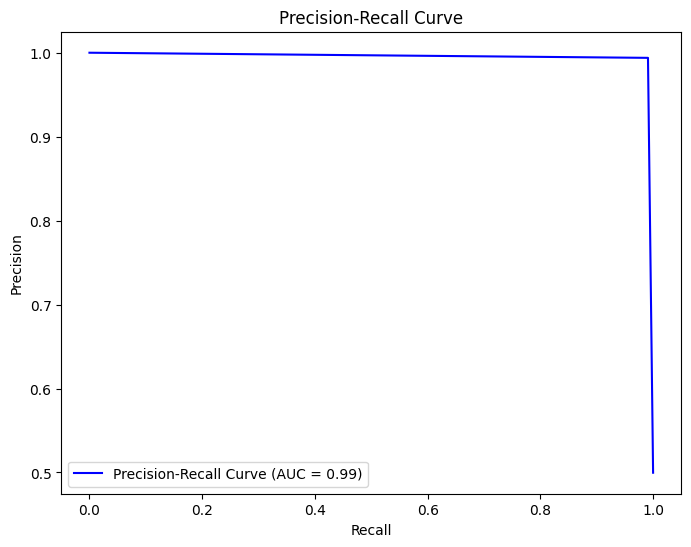

In [39]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_pred_logistic)
auc_score = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

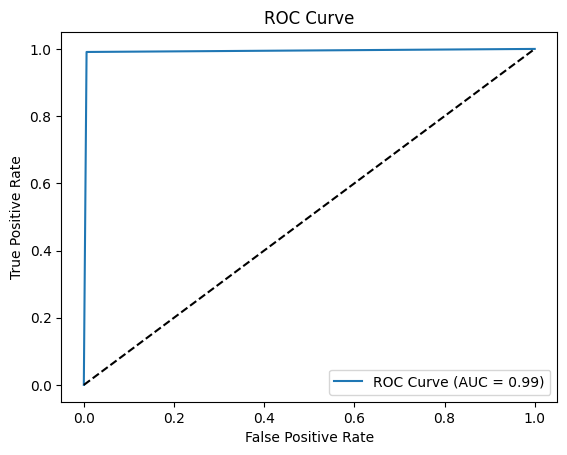

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_logistic)
auc = roc_auc_score(y_test, y_pred_logistic)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Decision Tree

In [41]:
pipeline_xgboost = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('xgboost', XGBClassifier()) 
])

In [42]:
pipeline_xgboost.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [43]:
y_pred_xgboost = pipeline_xgboost.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(y_test, y_pred_xgboost)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_xgboost, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9911817876921315
Precision: 0.9911842798590417
Recall: 0.9911817876921315
F1 Score: 0.9911817706732596


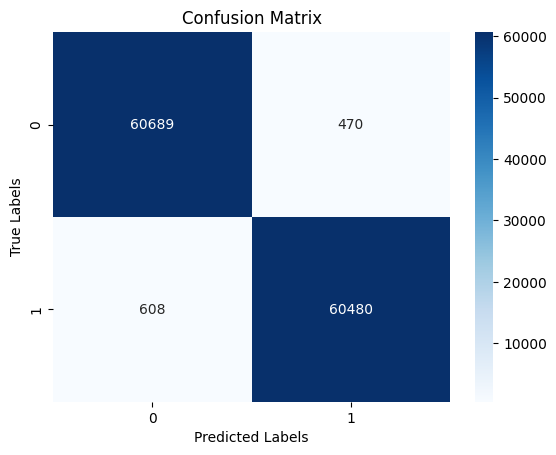

In [45]:
cm = confusion_matrix(y_test, y_pred_xgboost)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

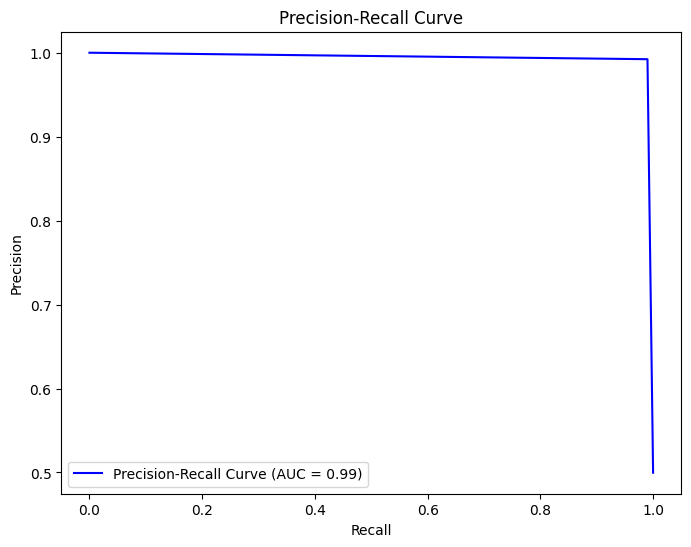

In [46]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_pred_xgboost)
auc_score = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

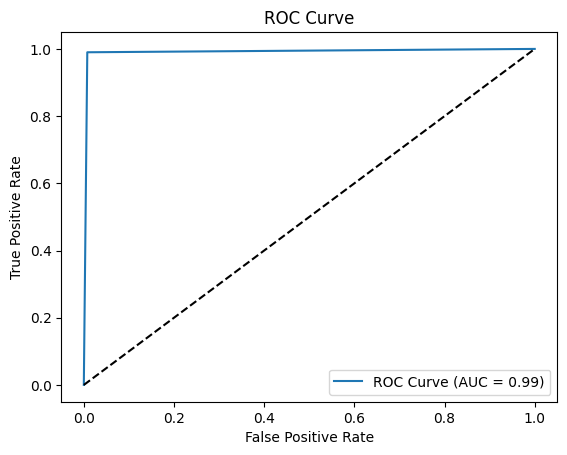

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgboost)
auc = roc_auc_score(y_test, y_pred_xgboost)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Test

In [50]:
# Define a dictionary to store your pipelines
pipelines = {
    "Naive Bayes": pipeline_bayes,
    "Logistic Regression": pipeline_logistic,
    "XGBoost": pipeline_xgboost
}

input_text = [
    "Sitting beneath the shade of an apple tree on a sunny day, a child with a book of fairy tales found solace. Lost in the pages, a bird's cheerful melody pierced the tranquility nearby. Enveloped by the sounds of nature, the child drifted into a world of fantasy."
]
# Loop through each pipeline name and test it
for name, pipeline in pipelines.items():
    # Predict class and probabilities using the current pipeline
    predicted_class = pipeline.predict(input_text)
    predicted_probabilities = pipeline.predict_proba(input_text)

    print(f"\nResults for pipeline: {name}")
    if predicted_class[0] == 0:
        print("Predicted class: Human")
    elif predicted_class[0] == 1:
        print("Predicted class: AI")
    print("Probability of being Human:", predicted_probabilities[0][0])
    print("Probability of being AI:", predicted_probabilities[0][1])



Results for pipeline: Naive Bayes
Predicted class: AI
Probability of being Human: 0.006981843330611821
Probability of being AI: 0.9930181566693901

Results for pipeline: Logistic Regression
Predicted class: AI
Probability of being Human: 0.011773412938594685
Probability of being AI: 0.9882265870614053

Results for pipeline: XgBoost
Predicted class: AI
Probability of being Human: 0.006433904
Probability of being AI: 0.9935661


## Saving My Pipeline for Deployment

In [51]:
import joblib

joblib.dump(pipeline_xgboost, 'pipeline_model.joblib')

['pipeline_model.joblib']